# TP: Propagación de Fake News y su impacto en la afinidad política de una sociedad

## Descripción del modelo

Este modelo surge de la pregunta: ¿Cómo influye la propagación de fake news en la afinidad política de las personas?
Para intentar responderla decidimos realizar un modelo mediante el cual representamos una dinámica simplificada de la propagación de una noticia falsa en diversos grupos sociales y cómo ésta puede modificar el pensamiento o afinidad politica hacia un determinado partido político en cada grupo social.


Para esto proponemos modelar un generador de fake news, que envía las mismas a distintos medios de comunicación, quienes a su vez las dispersan en los grupos sociales. 
Luego, los grupos sociales al sacar una conclusión respecto a la fake news, emiten su opinión al resto de los grupos a través de las redes sociales.

## Modelo conceptual 
 IMAGEN


El modelo cuenta con diferentes hipótesis:

    - Sólo consideramos dos bandos políticos: oficialismo y oposición
    - Hay dos tipos de medios de comunicación: oficialista y oposición
    - Las fakenews atacan a uno de los dos bandos políticos

### Descripción de los atómicos

- Generador: Cada fake news que emite el generador tiene la siguiente información: 
    - Afinidad al gobierno: 0/1 (0 = afin oposición , 1= afin oficialismo)
    - Urgencia de la noticia: valor real [0,1]
    - Credibilidad: valor real [0,1]
    
- Medios de comunicación: Cada fake news que "llega" al medio, luego se emite a los grupos sociales con la misma información que antes, sólo que el valor de credibilidad puede modificarse. (Si el medio y la fake coinciden en su afinidad al gobierno entonces la credibilidad se mantiene en el mismo valor, si el medio tiene afinidad opuesta a la fake news el campo de credibilidad se convierte en "0")

- Redes sociales: Cada fake emitida por los grupos sociales ingresan a las redes. El mensaje enviado contendrá la información sobre la fake y además los traits de la población emisora. Este mensaje, luego se enviará al resto de grupos sociales.

- Poblaciones: Cada grupo social tendra los siguientes traits constantes:
    - Edad 
    - Estudios universitarios
    - Nivel de involucramiento político
    - Estado laboral:
    - Nivel económico:
    - Centralidad:
  Y además el siguiente trait dinámico
    - Afinidad política:
   Éste va cambiando a medida que el grupo interactúa con las distintas fake news.  
    


Hipótesis:
- Es más probable creer en una fake news recibida de un medio si:
    - No fuiste a la universidad
    - Estás en algún extremo socioeconómico
    - Tu estado laboral es precario
    - Tu involucramiento en la política es bajo
    - Coincidencia entre la afinidad política de la fake y la de la población receptora
    - Coincidencia entre la afinidad política del medio emisor la fake y la de la población receptora
    - La fake news trata un tema urgente


- Es más probable creer en una fake news recibida de otra población si:
    - Se comparte una mayor cantidad de traits con la población de la que se recibe la fake news
    - La centralidad de la población emisora es alta
    - La creencia de la población emisora en la fake news es alta 
    - Coincidencia del bando político de la fake news con la afinidad política de la población receptora


## Modelo y componentes

Dibujo del top, generator, medios, redes y coupled poblaciones

In [2]:
from pathlib import Path

SED_HOME = Path.home().joinpath('SED')

#Directorio base donde está instalado el siumulador
CDPP_DIR = SED_HOME.joinpath('CDPP_ExtendedStates-codename-Santi')

CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

### - FakeNewsPropagation

Para observar el archivo fakeNewspropagation.ma:


In [37]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/model/

cat fakeNewsPropagation.ma

[top]
components : fakenewsgenerator@fakenewsgenerator mediaOfficial@media mediaOpposition@media populationscoupled
out : out_port
in : stop
link : stop stop@fakenewsgenerator
link : out@fakenewsgenerator in@mediaOfficial
link : out@fakenewsgenerator in@mediaOpposition
link : out@mediaOfficial news@populationscoupled
link : out@mediaOpposition news@populationscoupled
link : out_port@populationscoupled out_port

[fakenewsgenerator]
frequency : 00:00:03:00

[mediaOfficial]
party : 1

[mediaOpposition]
party : 0

[populationscoupled]
components : socialnetworks@socialnetworks population1@population population2@population population3@population population4@population 
out : out_port
in : news
link : news in@population1
link : news in@population2
link : news in@population3
link : news in@population4
link : news in@population5
link : news in@population6
link : news in@population7
link : news in@population8
link : out@population1 in@socialnetworks
link : out@population2 in@socialnetworks
link

### Atómicos

- Generator


Dibujo generator

In [18]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

cat FakeNewsGenerator.h

/*******************************************************************
*
*  DESCRIPTION: class FakeNewsGenerator
*
*  AUTHOR: Amalia & Mariana & Matias
*
*  DATE: 30/9/2021
*
*******************************************************************/

#ifndef __FakeNewsGenerator_H
#define __FakeNewsGenerator_H

/** include files **/
#include "atomic.h"     // class Atomic
#include "except.h"     // class InvalidMessageException
#include <random>

#define GEN_MODEL_NAME "FakeNewsGenerator"

/** declarations **/
class FakeNewsGenerator : public Atomic
{
public:
	FakeNewsGenerator( const std::string &name = GEN_MODEL_NAME );				  // Default constructor

	virtual std::string className() const
		{return "FakeNewsGenerator";}

protected:
	Model &initFunction() ;

	Model &externalFunction( const ExternalMessage & );

	Model &internalFunction( const InternalMessage & );

	Model &outputFunction( const CollectMessage & );

private:
	const Port &stop;
	Port &out ;
	VTime preparationTime;

	std::uniform_in

In [38]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

cat FakeNewsGenerator.cpp

/*******************************************************************
*
*  DESCRIPTION: class FakeNewsGenerator
*
*  AUTHOR: Amalia & Mariana & Matias
*
*  DATE: 30/9/2021
*
*******************************************************************/

/** include files **/
#include "FakeNewsGenerator.h"       // base header
#include "message.h"       // class InternalMessage 
#include "parsimu.h"      // class Simulator
#include "strutil.h"       // str2Value( ... )
#include <random>
#include "real.h"
#include "tuple_value.h"

using namespace std;

/*******************************************************************
* Function Name: Generator
* Description: constructor
********************************************************************/
FakeNewsGenerator::FakeNewsGenerator( const string &name )
	: Atomic( name ),
	  stop(addInputPort("stop")),
	  out( addOutputPort( "out" ) ),
	  dist_int(0,1),
	  dist_float(0.0,1.0),
	  rng(random_device()())
{

	string time( ParallelMainSimulator::Instance()

- Medios de comunicación (Media)

Dibujo

In [21]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

cat Media.h

/*******************************************************************
*
*  DESCRIPTION: class Media
*
*  AUTHOR: Amalia & Mariana & Matias
*
*  DATE: 30/9/2021
*
*******************************************************************/

#ifndef __Media_H
#define __Media_H

/** include files **/
#include "atomic.h"     // class Atomic
#include "except.h"     // class InvalidMessageException
#include <random>

#define MEDIA_MODEL_NAME "Media"

/** declarations **/
class Media : public Atomic
{
public:
	Media( const std::string &name = MEDIA_MODEL_NAME );				  // Default constructor

	virtual std::string className() const
		{return "Media";}

protected:
	Model &initFunction() ;

	Model &externalFunction( const ExternalMessage & );

	Model &internalFunction( const InternalMessage & );

	Model &outputFunction( const CollectMessage & );

private:
	const Port &in;	// this is an input port named 'in'
	Port &out ;   	// this is an output port named 'out'

	Real attacked_party;
	Real urgency;
	Real cr

In [22]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

cat FakeNewsGenerator.cpp

/*******************************************************************
*
*  DESCRIPTION: class FakeNewsGenerator
*
*  AUTHOR: Amalia & Mariana & Matias
*
*  DATE: 30/9/2021
*
*******************************************************************/

/** include files **/
#include "FakeNewsGenerator.h"       // base header
#include "message.h"       // class InternalMessage 
#include "parsimu.h"      // class Simulator
#include "strutil.h"       // str2Value( ... )
#include <random>
#include "real.h"
#include "tuple_value.h"

using namespace std;

/*******************************************************************
* Function Name: Generator
* Description: constructor
********************************************************************/
FakeNewsGenerator::FakeNewsGenerator( const string &name )
	: Atomic( name ),
	  stop(addInputPort("stop")),
	  out( addOutputPort( "out" ) ),
	  dist_int(0,1),
	  dist_float(0.0,1.0),
	  rng(random_device()())
{

	string time( ParallelMainSimulator::Instance()

- Social Networks

Dibujo

In [24]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

cat Media.h

/*******************************************************************
*
*  DESCRIPTION: class Media
*
*  AUTHOR: Amalia & Mariana & Matias
*
*  DATE: 30/9/2021
*
*******************************************************************/

#ifndef __Media_H
#define __Media_H

/** include files **/
#include "atomic.h"     // class Atomic
#include "except.h"     // class InvalidMessageException
#include <random>

#define MEDIA_MODEL_NAME "Media"

/** declarations **/
class Media : public Atomic
{
public:
	Media( const std::string &name = MEDIA_MODEL_NAME );				  // Default constructor

	virtual std::string className() const
		{return "Media";}

protected:
	Model &initFunction() ;

	Model &externalFunction( const ExternalMessage & );

	Model &internalFunction( const InternalMessage & );

	Model &outputFunction( const CollectMessage & );

private:
	const Port &in;	// this is an input port named 'in'
	Port &out ;   	// this is an output port named 'out'

	Real attacked_party;
	Real urgency;
	Real cr

In [ ]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

cat SocialNetworks.cpp

#include <random>
#include <string>
#include <stdlib.h>
#include <time.h>

#include "message.h"       
#include "parsimu.h"
#include "real.h"
#include "tuple_value.h"

#include "SocialNetworks.h"           

using namespace std;

#define VERBOSE true

#define PRINT_TIMES(f) {\
	VTime timeleft = nextChange();\
	VTime elapsed  = msg.time() - lastChange();\
	VTime sigma    = elapsed + timeleft;\
	cout << f << "@" << msg.time() <<\
		" - timeleft: " << timeleft <<\
		" - elapsed: " << elapsed <<\
		" - sigma: " << sigma << endl;\
}

SocialNetworks::SocialNetworks( const string &name ) : 
	Atomic( name ),
	out(addOutputPort( "out" )),
	in(addInputPort( "in" ))
{
	message;
}

Model &SocialNetworks::initFunction()
{
	// [(!) Initialize common variables]
	this->elapsed  = VTime::Zero;
 	this->timeLeft = VTime::Inf;
 	this->sigma = VTime::Inf; // stays in active state until an external event occurs;
 	
 	// set next transition
 	holdIn( AtomicState::passive, this->sigma  ) ;
	return *this ;
}



- Coupled Population

Dibujo

In [35]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

cat CoupledPopulation.h

#ifndef __CoupledPopulation_H
#define __CoupledPopulation_H

#include <random>
#include "atomic.h"  // class Atomic
#include "VTime.h"


#define COUPLEDPOP_MODEL_NAME "CoupledPopulation"

class CoupledPopulation: public Atomic{
	public:
		CoupledPopulation( const string &name = COUPLEDPOP_MODEL_NAME ) ;	 
		virtual string className() const {return COUPLEDPOP_MODEL_NAME ;}
	
	protected:
		Model &initFunction();	
		Model &externalFunction( const ExternalMessage & );
		Model &internalFunction( const InternalMessage & );
		Model &outputFunction( const CollectMessage & );
	
	private:
		 const Port &in;	
		 Port &out ;   	// this is an output port named 'out'

		Tuple<Real> message;
	
		VTime sigma;
		
		// Time elapsed since the last state transition until now
		VTime elapsed;
		
		// Time remaining to complete the last programmed Lifetime
		VTime timeLeft;	
};


#endif  


In [29]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

cat CoupledPopulation.cpp

#include <random>
#include <string>
#include <stdlib.h>
#include <time.h>

#include "message.h"       
#include "parsimu.h"
#include "real.h"
#include "tuple_value.h"

#include "CoupledPopulation.h"           

using namespace std;

#define VERBOSE true

#define PRINT_TIMES(f) {\
	VTime timeleft = nextChange();\
	VTime elapsed  = msg.time() - lastChange();\
	VTime sigma    = elapsed + timeleft;\
	cout << f << "@" << msg.time() <<\
		" - timeleft: " << timeleft <<\
		" - elapsed: " << elapsed <<\
		" - sigma: " << sigma << endl;\
}

CoupledPopulation::CoupledPopulation( const string &name ) : 
	Atomic( name ),
	out(addOutputPort( "out" )),
	in(addInputPort( "in" ))
{
	message;
}

Model &CoupledPopulation::initFunction()
{
	// [(!) Initialize common variables]
	this->elapsed  = VTime::Zero;
 	this->timeLeft = VTime::Inf;
 	this->sigma = VTime::Inf; // stays in active state until an external event occurs;
 	
 	// set next transition
 	holdIn( AtomicState::passive, this->sigma  ) ;
	return

- Population

Dibujo

In [32]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

cat Population.h

#ifndef __networkDelayType_H
#define __networkDelayType_H

#include <random>
#include "atomic.h"  // class Atomic
#include "VTime.h"


#define POP_MODEL_NAME "Population"

class Population: public Atomic{
	public:
		Population( const std::string &name = POP_MODEL_NAME ) ;	 

		virtual string className() const {return POP_MODEL_NAME ;}
	
	protected:
		Model &initFunction();	

		Model &externalFunction( const ExternalMessage & );
		
		Model &internalFunction( const InternalMessage & );

		Model &outputFunction( const CollectMessage & );
	
	private:
		 const Port &in;	
		 Port &out ;   

		Real population_id;
		Real age;
		Real university_studies;
		Real political_involvement;
		Real employment_status;		
		Real economic_status;
		Real centrality;
		Real political_affinity;

		Real current_fake_attacked_party;
		Real current_fake_urgency;
		Real current_fake_credibility;
		Real current_fake_media_party;
		Real current_fake_belief;

		bool is_message_received_from_media;
	
		VTime sigma;
		

In [31]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

cat Population.cpp

#include <random>
#include <string>
#include <stdlib.h>
#include <time.h>
#include <cmath>  //para el valor absoluto abs

#include "message.h"       
#include "parsimu.h"
#include "real.h"
#include "tuple_value.h"

#include "Population.h"           

using namespace std;


#define VERBOSE true

#define PRINT_TIMES(f) {\
	VTime timeleft = nextChange();\
	VTime elapsed  = msg.time() - lastChange();\
	VTime sigma    = elapsed + timeleft;\
	cout << f << "@" << msg.time() <<\
		" - timeleft: " << timeleft <<\
		" - elapsed: " << elapsed <<\
		" - sigma: " << sigma << endl;\
}

Population::Population( const string &name ) : 
	Atomic( name ),
	out(addOutputPort( "out" )),
	in(addInputPort( "in" )),
	population_id(500), //asumimos que no vamos a tener mas de 500 poblaciones? 
	age(100),
	university_studies(1),
	political_involvement(1),
	employment_status(1),
	economic_status(1),
	centrality(1),
	political_affinity(1),
	delay(1,59),
	rng(random_device()())
{
	population_id = str2Real( Parallel

## Para compilar el modelo:

In [39]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

# make clean

make -j4

make -C ../../../src/cd++ cd++ OUT_DIR=/home/mariana/SED/CDPP_ExtendedStates-codename-Santi/examples/fakeNewsPropagation-main/src/bin MODEL_FLAGS=-DREGISTER_ATOMICS
make[1]: Entering directory '/home/mariana/SED/CDPP_ExtendedStates-codename-Santi/src/cd++'
make -C /home/mariana/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/atomics OBJ_DIR=obj SRC_DIR=/home/mariana/SED/CDPP_ExtendedStates-codename-Santi/src/cd++ MODEL_FLAGS=-DREGISTER_ATOMICS
make -C /home/mariana/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/cell OBJ_DIR=obj SRC_DIR=/home/mariana/SED/CDPP_ExtendedStates-codename-Santi/src/cd++ MODEL_FLAGS=-DREGISTER_ATOMICS
make[2]: Entering directory '/home/mariana/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/atomics'
make -C /home/mariana/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/evt OBJ_DIR=obj SRC_DIR=/home/mariana/SED/CDPP_ExtendedStates-codename-Santi/src/cd++ MODEL_FLAGS=-DREGISTER_ATOMICS
make -C cpu OBJ_DIR=obj SRC_DIR=/home/mariana/SED/CDPP_ExtendedStates-codenam

/usr/bin/ld: /home/mariana/SED/CDPP_ExtendedStates-codename-Santi/examples/fakeNewsPropagation-main/src/bin/libsimu.a(macroexp.o): in function `macroExpansion::expand[abi:cxx11]()':
/home/mariana/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/utils/macroexp.cpp:147: warning: the use of `tmpnam' is dangerous, better use `mkstemp'
/usr/bin/ld: warped/notime/obj/DebugStream.o: in function `DebugStream::interact()':
/home/mariana/SED/CDPP_ExtendedStates-codename-Santi/src/cd++/warped/notime/DebugStream.cpp:682: warning: the `gets' function is dangerous and should not be used.


## Simulación del modelo:

In [8]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/fakeNewsPropagation-main/src/

bin/cd++ -m ../model/fakeNewsPropagation.ma  \
         -e ../model/fakeNewsPropagation.ev  \
         -l ../fakeNewsPropagation.log \
         -o ../fakeNewsPropagation.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/fakeNewsPropagation.ma
Loading events from ../model/fakeNewsPropagation.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../fakeNewsPropagation.log
Output to: ../fakeNewsPropagation.out
Toler

## Análisis de Resultados

Para observar cómo influyeron las fakenews en los diversos grupos sociales, proponemos analizar el cambio individual del trait "afinidad_política" de algunos grupos individualmente y por otro lado observar cómo evolucionó la cantidad de grupos afines y opositores en el tiempo.

In [9]:
try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd
    

In [10]:
try:
    import scipy as sp
except:
    !pip install scipy
    import scipy as sp

In [11]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

In [16]:
# definimos los path a los archivos de interés
#OUT_FILENAME = "../fakeNewsPropagation.out"
OUT_FILENAME = str(CDPP_EXAMPLES)+"/fakeNewsPropagation-main/fakeNewsPropagation.out"
# con el script tuple_to_real elegimos el índice 0 de la 3-upla
# tuple_to_real.tuple_to_real(OUT_FILENAME, 0)

# definimos los nombres de las columnas en los dataframes de pandas
TIME_COL_ORIG = 'time_orig'
TIME_COL = 'time'
PORT_COL = 'port'
VALUE_COL_ORIG = 'value_orig'
VALUE_COL = 'value'
POPULATION_COL = 'population'
POLITICAL_AFFINITY = 'political_affinity'
MESSAGE_TYPE_COL = 'message_type'
MODEL_ORIGIN_COL = 'model_origin'
MODEL_DEST_COL = 'model_dest'

# parsea cada fila del dataframe
def parse_value(value):
    is_list = value.strip().startswith("[") and value.strip().endswith("]")
    if is_list:
        return tuple(float(num) for num in value.replace('[', '').replace(']', '').split(', '))
    return float(value)

#conversion VTime a float
def time_to_secs(time):
    h, m, s, ms, r = time.split(':')
    return float(h)*60*60. + float(m)*60. + float(s) + float(ms)/1000. + float(r)/1000.

#conversion string to list
def value_to_list(value):
    tempValue = value[1:-1]
    return tempValue.split(',')

df_converters = {
     VALUE_COL: parse_value,
     TIME_COL: time_to_secs
 }

salida = pd.read_csv(OUT_FILENAME,
                     delimiter=r'(?<!,)\s+',
                     engine='python',  # C engine doesnt work for regex
                     # Se puede usar esto para convertir los valores directamente:
                     # converters=df_converters,
                     names=[TIME_COL_ORIG, PORT_COL, VALUE_COL_ORIG]
                    )

salida[TIME_COL]  = salida.apply(lambda row: time_to_secs(row[TIME_COL_ORIG]), axis=1)
salida[VALUE_COL] = salida.apply(lambda row: value_to_list(str(row[VALUE_COL_ORIG])), axis=1)
salida[POPULATION_COL] = salida.apply(lambda row: value_to_list(str(row[VALUE_COL_ORIG]))[0], axis=1)
salida[POLITICAL_AFFINITY] = salida.apply(lambda row: value_to_list(str(row[VALUE_COL_ORIG]))[1], axis=1)


outs_estadisticos = salida.loc[ salida['value'].str.len() == 2]
population1 = outs_estadisticos.loc[ salida['population'] == '1']
population1
outs_estadisticos = salida.loc[ salida['value'].str.len() == 2]
population2 = outs_estadisticos.loc[ salida['population'] == '2']
population2
outs_estadisticos = salida.loc[ salida['value'].str.len() == 2]
population3 = outs_estadisticos.loc[ salida['population'] == '3']
population3
outs_estadisticos = salida.loc[ salida['value'].str.len() == 2]
population4 = outs_estadisticos.loc[ salida['population'] == '4']

outs_estadisticos = salida.loc[ salida['value'].str.len() == 2]
population5 = outs_estadisticos.loc[ salida['population'] == '5']

outs_estadisticos = salida.loc[ salida['value'].str.len() == 2]
population6 = outs_estadisticos.loc[ salida['population'] == '6']

outs_estadisticos = salida.loc[ salida['value'].str.len() == 2]
population7 = outs_estadisticos.loc[ salida['population'] == '7']

outs_estadisticos = salida.loc[ salida['value'].str.len() == 2]
population8 = outs_estadisticos.loc[ salida['population'] == '8']
population8.head()


,time_orig,port,value_orig,time,value,population,political_affinity
19,00:00:10:019:0,out_port,"[8, 0.986503]",10.019,"[8, 0.986503]",8,0.986503
57,00:00:29:025:0,out_port,"[8, 0.505339]",29.025,"[8, 0.505339]",8,0.505339
59,00:00:30:002:0,out_port,"[8, 0.45067]",30.002,"[8, 0.45067]",8,0.45067
73,00:00:37:029:0,out_port,"[8, 0.611071]",37.029,"[8, 0.611071]",8,0.611071


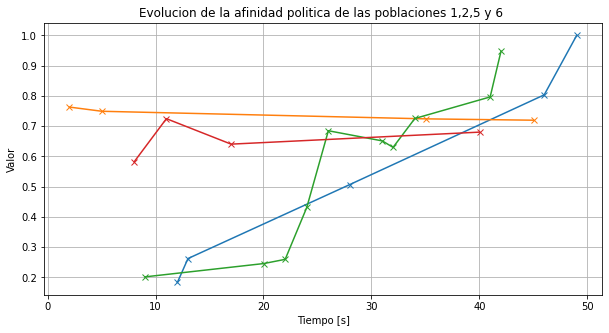

In [19]:
y_strings1 = population1[POLITICAL_AFFINITY].tolist()
x_string1 = population1[TIME_COL].tolist()
y_values1 = list(map(float, y_strings1))
x_values1 = list(map(float, x_string1))

y_strings2 = population2[POLITICAL_AFFINITY].tolist()
x_string2 = population2[TIME_COL].tolist()
y_values2 = list(map(float, y_strings2))
x_values2 = list(map(float, x_string2))

y_strings3 = population3[POLITICAL_AFFINITY].tolist()
x_string3 = population3[TIME_COL].tolist()
y_values3 = list(map(float, y_strings3))
x_values3 = list(map(float, x_string3))

y_strings4 = population4[POLITICAL_AFFINITY].tolist()
x_string4 = population4[TIME_COL].tolist()
y_values4 = list(map(float, y_strings4))
x_values4 = list(map(float, x_string4))

y_strings5 = population5[POLITICAL_AFFINITY].tolist()
x_string5 = population5[TIME_COL].tolist()
y_values5 = list(map(float, y_strings5))
x_values5 = list(map(float, x_string5))

y_strings6 = population6[POLITICAL_AFFINITY].tolist()
x_string6 = population6[TIME_COL].tolist()
y_values6 = list(map(float, y_strings6))
x_values6 = list(map(float, x_string6))

y_strings7 = population7[POLITICAL_AFFINITY].tolist()
x_string7 = population7[TIME_COL].tolist()
y_values7 = list(map(float, y_strings7))
x_values7 = list(map(float, x_string7))

y_strings8 = population8[POLITICAL_AFFINITY].tolist()
x_string8 = population8[TIME_COL].tolist()
y_values8 = list(map(float, y_strings8))
x_values8 = list(map(float, x_string8))

plt.figure(figsize=(10,5))
plt.plot( x_values1, y_values1,marker='x')
plt.plot( x_values2, y_values2,marker='x')
#plt.plot( x_values3, y_values3,marker='x')
#plt.plot( x_values4, y_values4,marker='x')
plt.plot( x_values5, y_values5,marker='x')
plt.plot( x_values6, y_values6,marker='x')
#plt.plot( x_values7, y_values7,marker='x')
#plt.plot( x_values8, y_values8,marker='x')
plt.grid(True)
plt.xlabel('Tiempo [s]')
plt.ylabel('Valor')
plt.title('Evolucion de la afinidad politica de las poblaciones 1,2,5 y 6 ');